***Name***: Sihan Cao

***Username***: acse-sc5323

***CID***: 02535863

## Data Exploration

Start by mounting Google-drive:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader

First we need to merge all the storm features into a single dataframe. After that, we can save it so that we can use it directly next time.

In [ ]:
# Directory path
csv_dir = '/Users/sc5323/ACSE/acds-the-day-after-tomorrow-ciaran/storm_data_csv'

# Initialize an empty dataframe
df = pd.DataFrame()

# Iterate through all the files in the directory
for filename in os.listdir(csv_dir):
    if filename.endswith('.csv'):
        file_path = os.path.join(csv_dir, filename)
        csv_df = pd.read_csv(file_path)
        df = df.append(csv_df, ignore_index=True)

# Save as a new CSV
df.to_csv("/content/drive/MyDrive/acds-the-day-after-tomorrow-ciaran/data.csv", index=False)

In [5]:
df = pd.read_csv("/Users/sc5323/ACSE/acds-the-day-after-tomorrow-ciaran/transformer for speed prediction/data.csv")

Have a look at the dataframe:

In [6]:
df.head()

,storm_id,relative_time,ocean,wind_speed,image_file_name
0,bkh,0,1,25,bkh_000.jpg
1,bkh,1801,1,25,bkh_001.jpg
2,bkh,3600,1,25,bkh_002.jpg
3,bkh,5400,1,25,bkh_003.jpg
4,bkh,7200,1,25,bkh_004.jpg


In [ ]:
df.shape

(9527, 5)

In [ ]:
storm_counts = df.groupby("storm_id").size()
storm_counts.describe()

count     30.000000
mean     317.566667
std      100.075035
min      155.000000
25%      244.500000
50%      312.500000
75%      396.250000
max      498.000000
dtype: float64

We can see that we have 30 storms and each storm has 317 images in average.

In [ ]:
df.groupby("ocean")["storm_id"].nunique()

ocean
1    24
2     6
Name: storm_id, dtype: int64

In [ ]:
wind_speed_counts = df.groupby("wind_speed").size()
wind_speed_counts.describe()

count    131.000000
mean      72.725191
std      114.996258
min        2.000000
25%       12.000000
50%       41.000000
75%       81.500000
max      665.000000
dtype: float64

Text(0.5, 1.0, 'Distribution of Wind Speeds')

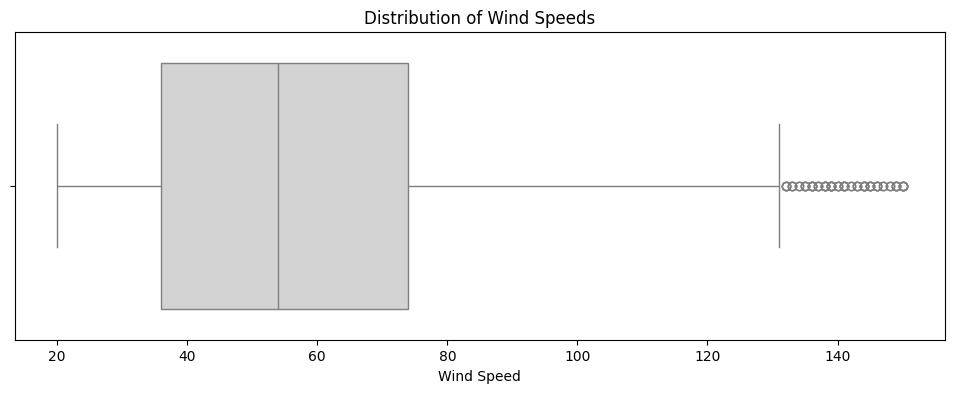

In [ ]:
plt.figure(figsize=(12, 4))
sns.boxplot(x=df.wind_speed, color="lightgray")
plt.xlabel("Wind Speed")
plt.title("Distribution of Wind Speeds")

In [25]:
def plot_wind_speeds(df, storm_id):
    storm = df[df.storm_id == storm_id]
    plt.figure(figsize=(12, 4))
    plt.scatter("relative_time", "wind_speed", data=storm, color="lightgray")
    plt.ticklabel_format(useOffset=False)
    plt.ylabel("Wind Speed")
    plt.title(f"Wind Speed over Relative Time: Storm {storm_id}")

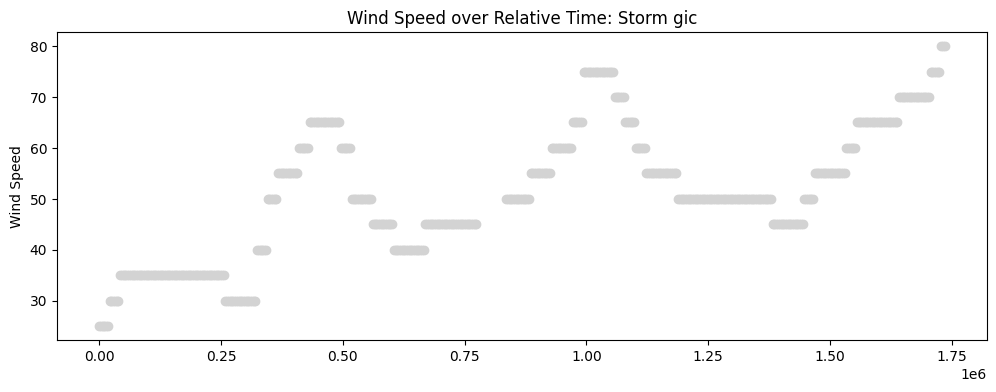

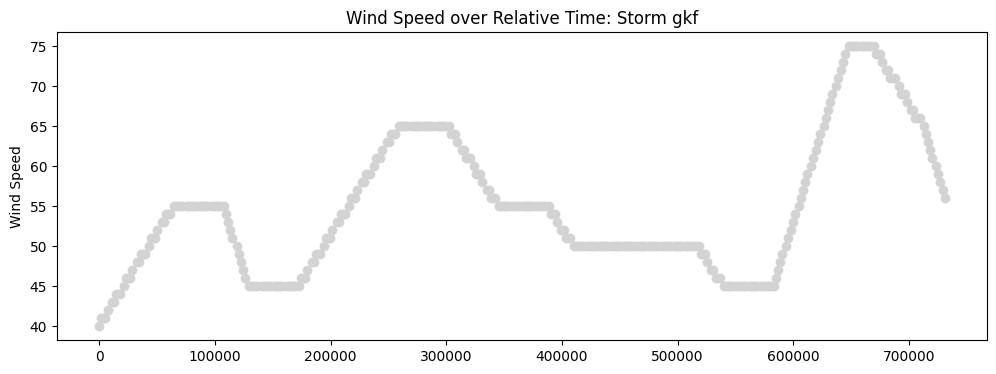

In [ ]:
# Sample two random storms
for storm in df.storm_id.sample(2, random_state=42):
    plot_wind_speeds(df, storm)

Take a look at the image size:

In [ ]:
img_dir = '/Users/sc5323/ACSE/acds-the-day-after-tomorrow-ciaran/all_storm_image/'
examples = [Image.open(img_dir + df.iloc[i]["image_file_name"]) for i in range(5)]
for image in examples:
    print(image.size)

(366, 366)
(366, 366)
(366, 366)
(366, 366)
(366, 366)


## Image Feature Extraction

In [30]:
# Define a simple model using a pretrained ResNet
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # Remove the last fully connected layer

    def forward(self, x):
        return self.features(x)

# Define preprocessing transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Use the input size of the pretrained ResNet model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
def extract_features_from_images(img_dir):
    # Initialize and load the model
    model = FeatureExtractor()
    model.eval()

    # Store all features in a list of dictionaries
    all_features = []

    # Iterate through all images in the image folder
    for filename in os.listdir(img_dir):
        if filename.endswith(".jpg"):
            # Load the image and preprocess it
            image_path = os.path.join(img_dir, filename)
            image = Image.open(image_path).convert("RGB")
            image_tensor = transform(image).unsqueeze(0)

            # Get the features
            feature_map = model(image_tensor)

            # Flatten the features into a one-dimensional array and store as a dictionary
            feature_dict = {"image_file_name": filename}
            for i, feature in enumerate(feature_map.squeeze().detach().numpy()):
                feature_dict[f"feature_{i+1}"] = feature

            # Store the feature dictionary
            all_features.append(feature_dict)

    # Convert the list of features into a DataFrame
    features_df = pd.DataFrame(all_features)

    # Merge the two DataFrames
    all_features_df = pd.merge(df, features_df, on="image_file_name", how="left")
    path = '/Users/sc5323/ACSE/acds-the-day-after-tomorrow-ciaran/transformer for speed prediction/all_data.csv'
    all_features_df.to_csv(path, index=False)

In [7]:
extract_features_from_images(img_dir)
all_features_df = pd.read_csv("/Users/sc5323/ACSE/acds-the-day-after-tomorrow-ciaran/transformer for speed prediction/all_data.csv")

In [8]:
all_features_df

,storm_id,relative_time,ocean,wind_speed,image_file_name,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,feature_512
0,bkh,0,1,25,bkh_000.jpg,0.016880,0.878463,0.338815,0.085504,0.037143,...,0.322232,0.304132,0.000000,0.098972,0.021013,0.145615,0.101595,0.403735,0.841953,0.000000
1,bkh,1801,1,25,bkh_001.jpg,0.010213,0.861812,0.231640,0.278531,0.068577,...,0.505706,0.217971,0.000000,0.420947,0.008675,0.263903,0.040202,0.372365,1.069459,0.024601
2,bkh,3600,1,25,bkh_002.jpg,0.005793,0.842504,0.379336,0.234381,0.192535,...,0.697075,0.104043,0.000401,0.875779,0.098873,0.816921,0.099449,0.370122,0.974086,0.085301
3,bkh,5400,1,25,bkh_003.jpg,0.008239,0.544057,0.174263,0.241958,0.181114,...,0.304748,0.092348,0.000000,0.629707,0.129769,0.513315,0.030281,0.221353,0.456096,0.060799
4,bkh,7200,1,25,bkh_004.jpg,0.000226,0.585094,0.261772,0.124366,0.091975,...,0.412388,0.114380,0.007355,0.790311,0.253398,0.756357,0.146837,0.109748,0.459954,0.054956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9522,ztb,550801,1,44,ztb_253.jpg,1.038711,0.539855,0.000000,0.442139,0.600721,...,0.104585,0.376220,0.738693,0.666582,0.018340,1.962785,0.723159,0.078232,0.586962,1.293018
9523,ztb,552603,1,43,ztb_254.jpg,0.598585,0.011730,0.000000,1.257612,0.248567,...,0.319591,0.834922,0.438838,0.637899,0.087973,2.395076,0.649098,0.155608,0.687842,0.760194
9524,ztb,554401,1,42,ztb_255.jpg,0.179882,0.219027,0.072969,0.370356,0.550516,...,0.178966,0.655741,0.390351,0.939865,0.400387,2.553669,0.864343,0.162744,0.189575,1.112016
9525,ztb,556202,1,42,ztb_256.jpg,0.266631,0.211366,0.007474,0.911477,0.349319,...,0.206882,0.709854,0.234636,1.147630,0.080113,1.937039,0.680715,0.039023,0.307725,0.695946


## Transformer Model

In [9]:
tfm_df = all_features_df.copy()
tfm_df = tfm_df[['image_file_name'] + [col for col in tfm_df.columns if col != 'image_file_name']]
tfm_df = tfm_df[['wind_speed'] + [col for col in tfm_df.columns if col != 'wind_speed']]
tfm_df

,wind_speed,image_file_name,storm_id,relative_time,ocean,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,feature_512
0,25,bkh_000.jpg,bkh,0,1,0.016880,0.878463,0.338815,0.085504,0.037143,...,0.322232,0.304132,0.000000,0.098972,0.021013,0.145615,0.101595,0.403735,0.841953,0.000000
1,25,bkh_001.jpg,bkh,1801,1,0.010213,0.861812,0.231640,0.278531,0.068577,...,0.505706,0.217971,0.000000,0.420947,0.008675,0.263903,0.040202,0.372365,1.069459,0.024601
2,25,bkh_002.jpg,bkh,3600,1,0.005793,0.842504,0.379336,0.234381,0.192535,...,0.697075,0.104043,0.000401,0.875779,0.098873,0.816921,0.099449,0.370122,0.974086,0.085301
3,25,bkh_003.jpg,bkh,5400,1,0.008239,0.544057,0.174263,0.241958,0.181114,...,0.304748,0.092348,0.000000,0.629707,0.129769,0.513315,0.030281,0.221353,0.456096,0.060799
4,25,bkh_004.jpg,bkh,7200,1,0.000226,0.585094,0.261772,0.124366,0.091975,...,0.412388,0.114380,0.007355,0.790311,0.253398,0.756357,0.146837,0.109748,0.459954,0.054956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9522,44,ztb_253.jpg,ztb,550801,1,1.038711,0.539855,0.000000,0.442139,0.600721,...,0.104585,0.376220,0.738693,0.666582,0.018340,1.962785,0.723159,0.078232,0.586962,1.293018
9523,43,ztb_254.jpg,ztb,552603,1,0.598585,0.011730,0.000000,1.257612,0.248567,...,0.319591,0.834922,0.438838,0.637899,0.087973,2.395076,0.649098,0.155608,0.687842,0.760194
9524,42,ztb_255.jpg,ztb,554401,1,0.179882,0.219027,0.072969,0.370356,0.550516,...,0.178966,0.655741,0.390351,0.939865,0.400387,2.553669,0.864343,0.162744,0.189575,1.112016
9525,42,ztb_256.jpg,ztb,556202,1,0.266631,0.211366,0.007474,0.911477,0.349319,...,0.206882,0.709854,0.234636,1.147630,0.080113,1.937039,0.680715,0.039023,0.307725,0.695946


First we tried the whole process of the Transformer model. But it turned out to be too slow and unnecessary, so we made subsequent adjustments. Below is the code to try.

In [ ]:
class WindSpeedDataset(Dataset):
    def __init__(self, features_df, sequence_length=10):
        self.features_df = features_df
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.features_df) - self.sequence_length + 1

    def __getitem__(self, idx):
        sequence = self.features_df.iloc[idx:idx+self.sequence_length]
        features = sequence.iloc[:, 1:-1].values
        target = sequence.iloc[-1, -1]
        return torch.tensor(features, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_heads):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        self.transformer = nn.Transformer(d_model=hidden_size, nhead=num_heads, num_encoder_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, tgt):
        x = self.embedding(x)
        x = self.transformer(x, tgt)
        x = self.fc(x[-1, :, :])  # Use the output of the last time step as prediction
        return x

In [13]:
def train_transformer_model(train_data, transformer_model, num_epochs=5, batch_size=16, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(transformer_model.parameters(), lr=learning_rate)

    # Used to store the predictions and actual values of the last epoch
    predictions = []
    actuals = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        N = 0
        for storm_id, group_data in train_data.groupby('storm_id'):
            group_data = group_data.drop(columns=['storm_id', 'relative_time', 'ocean'])
            columns = group_data.columns.tolist()
            new_columns = columns[1:] + [columns[0]]
            group_data = group_data[new_columns]

            sequence_length = 10
            wind_speed_dataset = WindSpeedDataset(group_data, sequence_length=sequence_length)
            data_loader = DataLoader(wind_speed_dataset, batch_size=batch_size, shuffle=True)

            for batch_features, batch_targets in data_loader:
                batch_features = batch_features.permute(1, 0, 2)

                tgt_tensor = batch_targets.unsqueeze(0)
                tgt_tensor = tgt_tensor.unsqueeze(-1)
                tgt_tensor = tgt_tensor.expand(sequence_length, -1, 512)

                outputs = transformer_model(batch_features, tgt=tgt_tensor)

                loss = criterion(outputs, batch_targets.unsqueeze(1))
                total_loss += loss.item()*len(batch_targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # If it's the last epoch, save the predictions and actual values
                if epoch == num_epochs - 1:
                    predictions.extend(outputs.detach().numpy())
                    actuals.extend(batch_targets.numpy())

            N += len(wind_speed_dataset)

        total_loss = total_loss / N
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

    # Create DataFrame
    results_df = pd.DataFrame({"Actual": actuals, "Predicted": predictions})
    results_df['Predicted'] = results_df['Predicted'].str[0]
    return results_df

In [ ]:
input_size = 512
hidden_size = 512
num_layers = 2
output_size = 1
num_heads = 4

transformer_model = TransformerModel(input_size, hidden_size, num_layers, output_size, num_heads)

train_transformer_model(tfm_df, transformer_model, num_epochs=10, batch_size=32, learning_rate=0.0001)

The decoder in the Transformer architecture is not very useful for this task. So we ended up using only the encoder for the prediction task.

In [10]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_heads):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        # The key part to edit
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dim_feedforward=hidden_size), num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, tgt=None):
        x = self.embedding(x)
        x = self.encoder(x, tgt)
        x = self.fc(x[-1, :, :])  # Use the output of the last time step as prediction
        return x

def train_transformer_model(train_data, transformer_model, num_epochs=5, batch_size=32, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(transformer_model.parameters(), lr=learning_rate)

    # Used to store the predictions and actual values of the last epoch
    predictions = []
    actuals = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        N = 0
        for storm_id, group_data in train_data.groupby('storm_id'):
            columns=['storm_id', 'relative_time', 'ocean']
            # columns=['relative_time']
            group_data = group_data.drop(columns=columns)
            columns = group_data.columns.tolist()
            new_columns = columns[1:] + [columns[0]]
            group_data = group_data[new_columns]

            sequence_length = 10
            wind_speed_dataset = WindSpeedDataset(group_data, sequence_length=sequence_length)
            data_loader = DataLoader(wind_speed_dataset, batch_size=batch_size, shuffle=True)

            for batch_features, batch_targets in data_loader:
                batch_features = batch_features.permute(1, 0, 2)
                # Do not have tgt here
                outputs = transformer_model(batch_features)

                loss = criterion(outputs, batch_targets.unsqueeze(1))
                total_loss += loss.item()*len(batch_targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # If it's the last epoch, save the predictions and actual values
                if epoch == num_epochs - 1:
                    predictions.extend(outputs.detach().numpy())
                    actuals.extend(batch_targets.numpy())

            N += len(wind_speed_dataset)

        total_loss = total_loss / N
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

    # Create DataFrame
    results_df = pd.DataFrame({"Actual": actuals, "Predicted": predictions})
    results_df['Predicted'] = results_df['Predicted'].str[0]
    return results_df

In [ ]:
input_size = 512
hidden_size = 512
num_layers = 4
output_size = 1
num_heads = 8

transformer_model = TransformerModel(input_size, hidden_size, num_layers, output_size, num_heads)

results_df = train_transformer_model(tfm_df, transformer_model, num_epochs=15, batch_size=64, learning_rate=0.0001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/15], Loss: 2524.5693
Epoch [2/15], Loss: 1904.7173
Epoch [3/15], Loss: 1423.2658
Epoch [4/15], Loss: 1111.2375
Epoch [5/15], Loss: 900.7833
Epoch [6/15], Loss: 777.0853
Epoch [7/15], Loss: 723.9759
Epoch [8/15], Loss: 706.2388
Epoch [9/15], Loss: 708.4296
Epoch [10/15], Loss: 683.8800
Epoch [11/15], Loss: 682.4623
Epoch [12/15], Loss: 682.6521
Epoch [13/15], Loss: 683.1330
Epoch [14/15], Loss: 683.6198
Epoch [15/15], Loss: 683.7480


In [ ]:
results_df.head()

,Actual,Predicted
0,40.0,58.863964
1,35.0,58.990139
2,85.0,58.983788
3,39.0,58.912907
4,36.0,58.904205


Obviously, this method presents the problem of gradient disappearing. Reference this article ([Understanding the Difficulty of Training Transformers] (https://arxiv.org/abs/2004.08249)), I modified the parameter ` norm_first `. The code is modified as follows:

In [30]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_heads):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, norm_first=True), num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, tgt=None):
        x = self.embedding(x)
        x = self.encoder(x, tgt)
        x = self.fc(x[-1, :, :])  # Use the output of the last time step as prediction
        return x

In [16]:
input_size = 512
hidden_size = 512
num_layers = 3
output_size = 1
num_heads = 2

transformer_model = TransformerModel(input_size, hidden_size, num_layers, output_size, num_heads)

results_df = train_transformer_model(tfm_df, transformer_model, num_epochs=10, batch_size=32, learning_rate=0.0001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 493.6678
Epoch [2/10], Loss: 317.5114
Epoch [3/10], Loss: 241.4260
Epoch [4/10], Loss: 197.0143
Epoch [5/10], Loss: 165.7870
Epoch [6/10], Loss: 144.5001
Epoch [7/10], Loss: 133.4651
Epoch [8/10], Loss: 118.7478
Epoch [9/10], Loss: 104.3790
Epoch [10/10], Loss: 96.9249


In [17]:
results_df.head()

,Actual,Predicted
0,39.0,57.432156
1,56.0,60.233559
2,85.0,68.002686
3,32.0,44.244350
4,45.0,48.633419


## Some Trials

In this section, we tried to split a particular storm dataset into a training set and a test set. Test the trained model and check how it performs.

In [50]:
def test_transformer_model(test_data, transformer_model, batch_size=32):
    criterion = nn.MSELoss()
    predictions = []
    actuals = []

    total_loss = 0.0
    N = 0

    for storm_id, group_data in test_data.groupby('storm_id'):
        columns=['storm_id', 'relative_time', 'ocean']
        group_data = group_data.drop(columns=columns)
        columns = group_data.columns.tolist()
        new_columns = columns[1:] + [columns[0]]
        group_data = group_data[new_columns]

        sequence_length = 10
        wind_speed_dataset = WindSpeedDataset(group_data, sequence_length=sequence_length)
        data_loader = DataLoader(wind_speed_dataset, batch_size=batch_size, shuffle=False)

        for batch_features, batch_targets in data_loader:
            batch_features = batch_features.permute(1, 0, 2)
            outputs = transformer_model(batch_features)

            loss = criterion(outputs, batch_targets.unsqueeze(1))
            total_loss += loss.item()*len(batch_targets)

            predictions.extend(outputs.detach().numpy())
            actuals.extend(batch_targets.numpy())

        N += len(wind_speed_dataset)

    total_loss = total_loss / N
    print(f'Test Data Loss: {total_loss:.4f}')

    results_df = pd.DataFrame({"Actual": actuals, "Predicted": predictions})
    results_df['Predicted'] = results_df['Predicted'].str[0]
    return results_df

In [11]:
bkh_df = tfm_df[tfm_df['storm_id']=='bkh']
bkh_train = bkh_df[:len(bkh_df)-10]
bkh_test = bkh_df[len(bkh_df)-19:]

In [12]:
input_size = 512
hidden_size = 512
num_layers = 3
output_size = 1
num_heads = 2

transformer_model = TransformerModel(input_size, hidden_size, num_layers, output_size, num_heads)

results_df, result_model = train_transformer_model(bkh_train, transformer_model, num_epochs=20, batch_size=32, learning_rate=0.0001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Loss: 901.9246
Epoch [2/20], Loss: 284.6736
Epoch [3/20], Loss: 274.6441
Epoch [4/20], Loss: 239.0726
Epoch [5/20], Loss: 216.4820
Epoch [6/20], Loss: 186.3812
Epoch [7/20], Loss: 155.0026
Epoch [8/20], Loss: 130.2156
Epoch [9/20], Loss: 112.5765
Epoch [10/20], Loss: 67.1266
Epoch [11/20], Loss: 58.9549
Epoch [12/20], Loss: 52.9914
Epoch [13/20], Loss: 38.2514
Epoch [14/20], Loss: 21.5495
Epoch [15/20], Loss: 22.1880
Epoch [16/20], Loss: 17.3131
Epoch [17/20], Loss: 49.4205
Epoch [18/20], Loss: 165.9409
Epoch [19/20], Loss: 33.4206
Epoch [20/20], Loss: 26.7095


In [13]:
results_df

,Actual,Predicted
0,25.0,25.767750
1,25.0,25.767416
2,25.0,26.277880
3,25.0,25.605219
4,25.0,25.758833
...,...,...
386,30.0,33.128235
387,30.0,31.576830
388,30.0,33.025093
389,30.0,31.711740


In [14]:
r = test_transformer_model(bkh_test, result_model, batch_size=32)

Test Data Loss: 43.0166


In [15]:
r

,Actual,Predicted
0,30.0,32.936844
1,30.0,32.624489
2,30.0,34.813114
3,30.0,36.042480
4,30.0,39.177467
5,30.0,38.411648
6,30.0,36.581078
7,30.0,36.438251
8,30.0,38.064262
9,30.0,37.085197


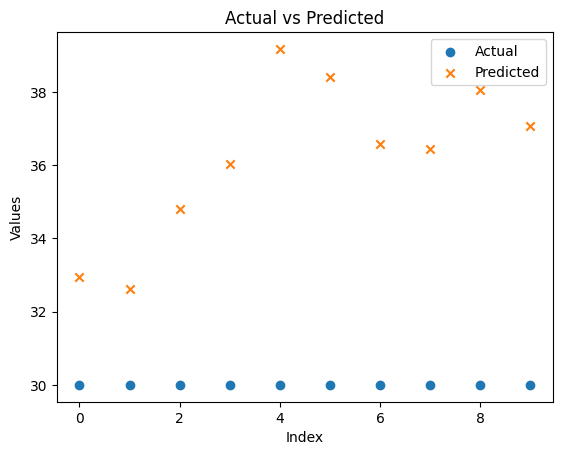

In [18]:
plt.scatter(r.index, r['Actual'], label='Actual', marker='o')
plt.scatter(r.index, r['Predicted'], label='Predicted', marker='x')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

As it turned out, that didn't work well. So we ended up training the model with all the data sets together.

## Surprise storm

In [51]:
ss_df = pd.read_csv("/Users/sc5323/ACSE/acds-the-day-after-tomorrow-ciaran/transformer for speed prediction/data_tst.csv")
ss_df

,storm_id,relative_time,ocean,wind_speed,image_file_name
0,tst,0,1,31.0,tst_000.jpg
1,tst,1800,1,32.0,tst_001.jpg
2,tst,3601,1,33.0,tst_002.jpg
3,tst,5400,1,33.0,tst_003.jpg
4,tst,7200,1,34.0,tst_004.jpg
...,...,...,...,...,...
250,tst,539999,1,NaN,tst_250.jpg
251,tst,541799,1,NaN,tst_251.jpg
252,tst,543599,1,NaN,tst_252.jpg
253,tst,545399,1,NaN,tst_253.jpg


Text(0.5, 1.0, 'Distribution of Wind Speeds')

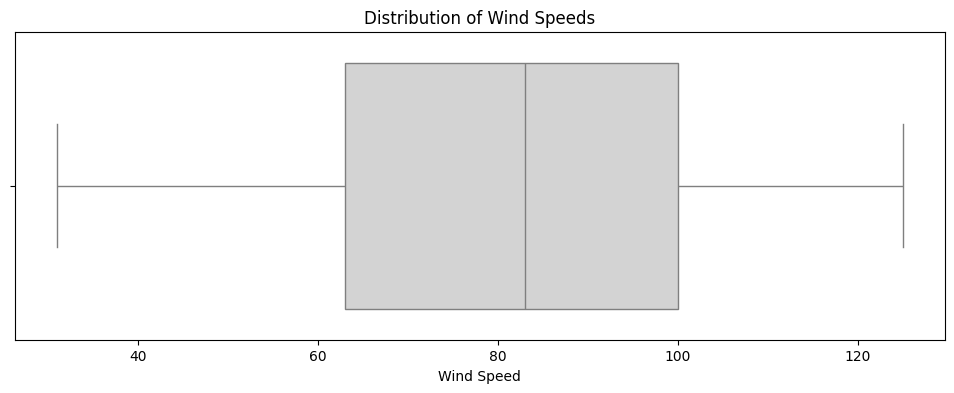

In [24]:
plt.figure(figsize=(12, 4))
sns.boxplot(x=ss_df.wind_speed, color="lightgray")
plt.xlabel("Wind Speed")
plt.title("Distribution of Wind Speeds")

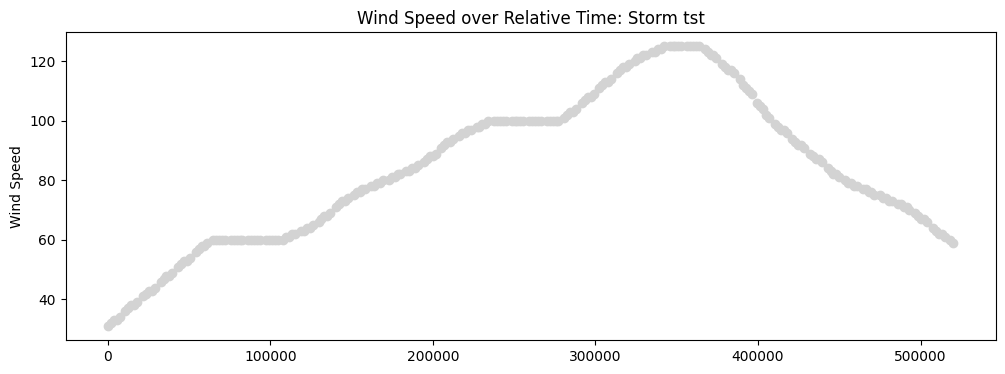

In [29]:
plot_wind_speeds(ss_df, storm_id='tst')

### Image Feature

In [31]:
ss_img_dir = '/content/drive/MyDrive/Storm_Project/transformer for speed prediction/surprise_storm_image/'

In [53]:
extract_features_from_images(ss_img_dir)
ss_all_features_df = pd.read_csv("/Users/sc5323/ACSE/acds-the-day-after-tomorrow-ciaran/transformer for speed prediction/ss_all_data.csv")

In [54]:
ss_all_features_df

,storm_id,relative_time,ocean,wind_speed,image_file_name,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,feature_512
0,tst,0,1,31.0,tst_000.jpg,0.253864,2.683766,0.236927,0.305156,0.352107,...,1.190530,0.715562,0.161097,0.641597,0.737630,0.387561,0.152709,0.232755,1.272517,1.082677
1,tst,1800,1,32.0,tst_001.jpg,0.222727,2.251039,0.294600,0.163028,0.161877,...,1.387395,0.686845,0.003000,0.541749,0.809814,0.181354,0.463816,0.185061,1.560249,0.606772
2,tst,3601,1,33.0,tst_002.jpg,0.121357,2.408053,0.252693,0.028164,0.052781,...,1.251746,0.982607,0.005957,0.592558,0.779335,0.108757,0.397874,0.020360,1.285508,0.991122
3,tst,5400,1,33.0,tst_003.jpg,0.030754,3.436396,0.145525,0.182202,0.115081,...,1.289519,1.084308,0.152005,0.273278,0.826521,0.255024,0.188492,0.154091,1.264987,0.647586
4,tst,7200,1,34.0,tst_004.jpg,0.023712,2.703913,0.068276,0.216655,0.094751,...,1.105289,0.933157,0.297464,0.432388,0.736379,0.545954,0.138617,0.137584,1.153430,0.819153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,tst,539999,1,NaN,tst_250.jpg,0.256084,0.860313,0.508502,0.797235,0.268882,...,0.076742,0.781351,0.000000,0.427417,0.398035,0.341471,0.037307,0.058719,0.719805,0.649078
251,tst,541799,1,NaN,tst_251.jpg,0.736789,2.078864,0.372064,1.051764,0.670630,...,0.037778,0.558010,0.000000,1.153110,0.186247,0.467130,0.349190,0.165016,0.487558,0.578739
252,tst,543599,1,NaN,tst_252.jpg,0.048753,1.057620,0.387522,0.376547,0.028493,...,0.394064,0.870490,0.010401,0.536614,1.314289,0.262371,0.681118,0.061521,0.373097,1.029591
253,tst,545399,1,NaN,tst_253.jpg,0.069582,0.489772,0.223983,0.572301,0.393661,...,0.315002,0.782080,0.026951,1.089954,1.423362,0.523406,0.380483,0.167076,0.630352,0.991236


### Transformer Model

In [55]:
ss_tfm_df = ss_all_features_df.copy()
ss_tfm_df = ss_tfm_df[['image_file_name'] + [col for col in ss_tfm_df.columns if col != 'image_file_name']]
ss_tfm_df = ss_tfm_df[['wind_speed'] + [col for col in ss_tfm_df.columns if col != 'wind_speed']]
ss_tfm_df

,wind_speed,image_file_name,storm_id,relative_time,ocean,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,feature_512
0,31.0,tst_000.jpg,tst,0,1,0.253864,2.683766,0.236927,0.305156,0.352107,...,1.190530,0.715562,0.161097,0.641597,0.737630,0.387561,0.152709,0.232755,1.272517,1.082677
1,32.0,tst_001.jpg,tst,1800,1,0.222727,2.251039,0.294600,0.163028,0.161877,...,1.387395,0.686845,0.003000,0.541749,0.809814,0.181354,0.463816,0.185061,1.560249,0.606772
2,33.0,tst_002.jpg,tst,3601,1,0.121357,2.408053,0.252693,0.028164,0.052781,...,1.251746,0.982607,0.005957,0.592558,0.779335,0.108757,0.397874,0.020360,1.285508,0.991122
3,33.0,tst_003.jpg,tst,5400,1,0.030754,3.436396,0.145525,0.182202,0.115081,...,1.289519,1.084308,0.152005,0.273278,0.826521,0.255024,0.188492,0.154091,1.264987,0.647586
4,34.0,tst_004.jpg,tst,7200,1,0.023712,2.703913,0.068276,0.216655,0.094751,...,1.105289,0.933157,0.297464,0.432388,0.736379,0.545954,0.138617,0.137584,1.153430,0.819153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,NaN,tst_250.jpg,tst,539999,1,0.256084,0.860313,0.508502,0.797235,0.268882,...,0.076742,0.781351,0.000000,0.427417,0.398035,0.341471,0.037307,0.058719,0.719805,0.649078
251,NaN,tst_251.jpg,tst,541799,1,0.736789,2.078864,0.372064,1.051764,0.670630,...,0.037778,0.558010,0.000000,1.153110,0.186247,0.467130,0.349190,0.165016,0.487558,0.578739
252,NaN,tst_252.jpg,tst,543599,1,0.048753,1.057620,0.387522,0.376547,0.028493,...,0.394064,0.870490,0.010401,0.536614,1.314289,0.262371,0.681118,0.061521,0.373097,1.029591
253,NaN,tst_253.jpg,tst,545399,1,0.069582,0.489772,0.223983,0.572301,0.393661,...,0.315002,0.782080,0.026951,1.089954,1.423362,0.523406,0.380483,0.167076,0.630352,0.991236


### Split the data

In [58]:
ss_train = ss_tfm_df[:len(ss_tfm_df)-13]
ss_train

,wind_speed,image_file_name,storm_id,relative_time,ocean,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,feature_512
0,31.0,tst_000.jpg,tst,0,1,0.253864,2.683766,0.236927,0.305156,0.352107,...,1.190530,0.715562,0.161097,0.641597,0.737630,0.387561,0.152709,0.232755,1.272517,1.082677
1,32.0,tst_001.jpg,tst,1800,1,0.222727,2.251039,0.294600,0.163028,0.161877,...,1.387395,0.686845,0.003000,0.541749,0.809814,0.181354,0.463816,0.185061,1.560249,0.606772
2,33.0,tst_002.jpg,tst,3601,1,0.121357,2.408053,0.252693,0.028164,0.052781,...,1.251746,0.982607,0.005957,0.592558,0.779335,0.108757,0.397874,0.020360,1.285508,0.991122
3,33.0,tst_003.jpg,tst,5400,1,0.030754,3.436396,0.145525,0.182202,0.115081,...,1.289519,1.084308,0.152005,0.273278,0.826521,0.255024,0.188492,0.154091,1.264987,0.647586
4,34.0,tst_004.jpg,tst,7200,1,0.023712,2.703913,0.068276,0.216655,0.094751,...,1.105289,0.933157,0.297464,0.432388,0.736379,0.545954,0.138617,0.137584,1.153430,0.819153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,62.0,tst_237.jpg,tst,511201,1,0.079416,1.009398,0.147048,0.660305,0.324002,...,0.072675,1.158941,0.148444,1.016324,0.431274,0.536545,0.660592,0.209465,0.784665,0.111852
238,62.0,tst_238.jpg,tst,513000,1,0.032579,1.239635,0.134221,0.853692,0.440186,...,0.008471,0.912685,0.185309,1.069469,0.162056,0.660777,0.935962,0.308892,1.045737,0.713958
239,61.0,tst_239.jpg,tst,514800,1,0.081719,1.232577,0.353896,0.676765,0.533580,...,0.086218,0.492495,0.114022,1.368269,0.150845,1.053292,0.274615,0.111530,0.878491,0.686810
240,60.0,tst_240.jpg,tst,518400,1,0.077708,1.162276,0.150484,0.879249,0.549053,...,0.368882,0.418578,0.000000,1.923297,0.260309,0.257433,0.248520,0.080742,1.373766,0.440369


In [ ]:
ss_train = pd.concat([ss_train, tfm_df], ignore_index=True)

In [60]:
input_size = 512
hidden_size = 512
num_layers = 3
output_size = 1
num_heads = 2

transformer_model = TransformerModel(input_size, hidden_size, num_layers, output_size, num_heads)

results_df, result_model = train_transformer_model(ss_train, transformer_model, num_epochs=50, batch_size=32, learning_rate=0.0001)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50], Loss: 1440.7337
Epoch [2/50], Loss: 782.7937
Epoch [3/50], Loss: 772.0205
Epoch [4/50], Loss: 662.2978
Epoch [5/50], Loss: 512.3921
Epoch [6/50], Loss: 425.7729
Epoch [7/50], Loss: 407.5756
Epoch [8/50], Loss: 411.9643
Epoch [9/50], Loss: 394.7527
Epoch [10/50], Loss: 382.1092
Epoch [11/50], Loss: 343.4837
Epoch [12/50], Loss: 309.8621
Epoch [13/50], Loss: 276.4169
Epoch [14/50], Loss: 230.5413
Epoch [15/50], Loss: 195.8894
Epoch [16/50], Loss: 151.4031
Epoch [17/50], Loss: 119.8427
Epoch [18/50], Loss: 105.7967
Epoch [19/50], Loss: 94.3342
Epoch [20/50], Loss: 83.4068
Epoch [21/50], Loss: 77.0688
Epoch [22/50], Loss: 70.3964
Epoch [23/50], Loss: 61.1985
Epoch [24/50], Loss: 53.6743
Epoch [25/50], Loss: 48.6517
Epoch [26/50], Loss: 47.2932
Epoch [27/50], Loss: 48.6498
Epoch [28/50], Loss: 44.0703
Epoch [29/50], Loss: 45.9336
Epoch [30/50], Loss: 39.5829
Epoch [31/50], Loss: 40.1957
Epoch [32/50], Loss: 41.0091
Epoch [33/50], Loss: 38.6741
Epoch [34/50], Loss: 32.5680
Epoc

In [66]:
results_df.head()

,Actual,Predicted
0,75.0,75.256508
1,92.0,95.392082
2,55.0,57.045963
3,70.0,72.706726
4,30.0,27.123072


In [62]:
ss_predict = ss_tfm_df[len(ss_tfm_df)-22:]

In [63]:
def predict_transformer_model(predict_data, transformer_model, batch_size=32):
    predictions = []

    for storm_id, group_data in predict_data.groupby('storm_id'):
        columns=['storm_id', 'relative_time', 'ocean']
        group_data = group_data.drop(columns=columns)
        columns = group_data.columns.tolist()
        new_columns = columns[1:] + [columns[0]]
        group_data = group_data[new_columns]

        sequence_length = 10
        wind_speed_dataset = WindSpeedDataset(group_data, sequence_length=sequence_length)
        data_loader = DataLoader(wind_speed_dataset, batch_size=batch_size, shuffle=False)

        for batch_features, batch_targets in data_loader:
            batch_features = batch_features.permute(1, 0, 2)
            outputs = transformer_model(batch_features)
            predictions.extend(outputs.detach().numpy())

    results_df = pd.DataFrame({"Predicted": predictions})
    results_df['Predicted'] = results_df['Predicted'].str[0]
    return results_df

In [64]:
r = predict_transformer_model(ss_predict, result_model, batch_size=32)
r['Predicted'] = r['Predicted'].round().astype(int)
r

,Predicted
0,67
1,68
2,69
3,64
4,69
5,71
6,70
7,67
8,67
9,67


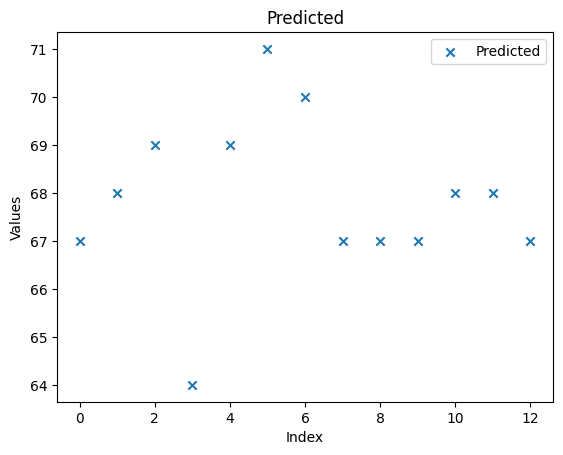

In [65]:
plt.scatter(r.index, r['Predicted'], label='Predicted', marker='x')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Predicted')
plt.legend()
plt.show()